# Docling + Mistral Graph Extraction (Advanced)

This notebook demonstrates an advanced workflow for extracting structured data from complex documents, like the sample insurance policy.

It uses a powerful two-stage process:
1.  **Docling (`VlmPipeline`)**: Converts the PDF into high-quality, layout-aware Markdown. This step understands the document's structure, tables, and reading order.
2.  **Mistral API (`mistral-large-latest`)**: A powerful general-purpose LLM reads the structured Markdown and the Pydantic schema to extract the complex data into a clean JSON object.
3.  **GraphConverter**: The resulting JSON is validated and converted into a NetworkX knowledge graph, just like in the previous notebook.

In [ ]:
%pip install -q docling pymupdf mistralai networkx matplotlib plotly pygraphviz rich

In [19]:
import os
import re
import sys
import json
import fitz  # PyMuPDF
from importlib import import_module

from rich import print
from IPython.display import Image, HTML, display
from pydantic import BaseModel, Field
from typing import Optional, List, Any

# Local inference imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Docling Imports for PDF-to-Markdown
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline

# scripts
sys.path.append('.')
try:
    from scripts.graph_converter import GraphConverter
    from scripts.graph_visualizer import create_static_graph, create_interactive_graph
except ImportError:
    print("[bold red]Warning: Could not find scripts/graph_converter.py or scripts/graph_visualizer.py.[/bold red]")
    print("Please ensure they are in a 'scripts' folder in the same directory as this notebook.")

## 1. Define Input Document and Pydantic Schema

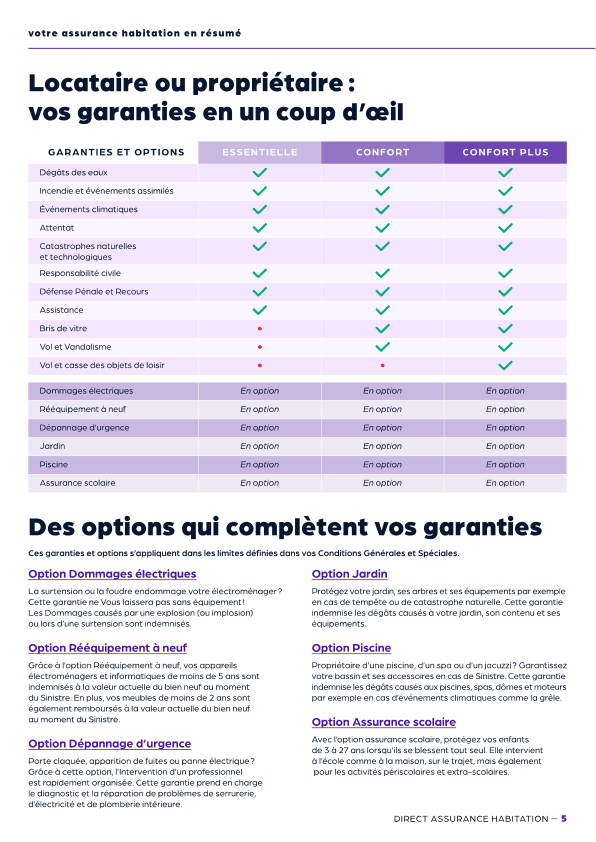

In [2]:
# We'll use the complex insurance document as our source
file_path = "data/assurance_options.pdf"
template_module = "insurance"
template_class = "HomeInsurance"

# Display the first page of the PDF for reference
if os.path.exists(file_path):
    doc = fitz.open(file_path)
    page = doc.load_page(0)
    pix = page.get_pixmap()
    output_image = "data/page_preview.png"
    pix.save(output_image)
    display(Image(filename=output_image))
else:
    print(f"[bold red]Error: Input file not found at {file_path}[/bold red]")

In [3]:
# Load the Pydantic Template from the templates/ folder
print(f"[bold green]Loading template: {template_module}.{template_class}[/bold green]")
try:
    TemplateModule = import_module(f"templates.{template_module}")
    Template = getattr(TemplateModule, template_class)
    print("Template loaded successfully.")
except ImportError:
    print(f"[bold red]Error: Could not import {template_class} from templates/{template_module}.py[/bold red]")
    Template = None

Loading template: insurance.HomeInsurance

Template loaded successfully.

## 2. Convert Document to Markdown

Using `docling.DocumentConverter` with `VlmPipeline` to get layout-aware Markdown. This uses the default `granite-docling` model to understand the document structure.

In [4]:
# This is the setup from your code snippet
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=VlmPipeline,
        ),
    })

source = file_path
markdown_content = None

if os.path.exists(source) and Template:
    print(f"Converting '{source}' to Markdown using Docling VlmPipeline...")
    doc = converter.convert(source=source).document
    markdown_content = doc.export_to_markdown()
    print(f"[bold green]Document converted. Markdown length: {len(markdown_content)}[/bold green]")
else:
    print(f"[bold red]Error: File not found at {source} or Template not loaded. Skipping conversion.[/bold red]")

Converting 'data/assurance_options.pdf' to Markdown using Docling VlmPipeline...

2025-10-22 20:48:59,543 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-22 20:48:59,589 - INFO - Going to convert document batch...
2025-10-22 20:48:59,590 - INFO - Initializing pipeline for VlmPipeline with options hash 14b35a24912cc09d5c7735b8ff9d88c1
2025-10-22 20:48:59,608 - INFO - Loading plugin 'docling_defaults'
2025-10-22 20:48:59,609 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-10-22 20:48:59,633 - INFO - Accelerator device: 'cuda:0'
2025-10-22 20:49:01,270 - INFO - Processing document assurance_options.pdf
2025-10-22 20:49:31,069 - INFO - Finished converting document assurance_options.pdf in 31.51 sec.


Document converted. Markdown length: 3589

### Review Markdown Content (Optional)

In [6]:
if markdown_content:
    print("--- Start of Markdown Snippet ---")
    print(markdown_content[:1000])  # Print first 1000 characters for brevity
    print("--- End of Markdown Snippet ---")

--- Start of Markdown Snippet ---

## Locataire ou propriétaire : vos garanties en un coup d'œil

| GARANTIES ET OPTIONS                      | ESSENTIELLE   | CONFOUR   | CONFORT PLUS   |
|-------------------------------------------|---------------|-----------|----------------|
| Dégâts des eaux                           | ✔             | ✔         | ✔              |
| Incendie et événements assimilés          | ✔             | ✔         | ✔              |
| Événements climatiques                    | ✔             | ✔         | ✔              |
| Attentat                                  | ✔             | ✔         | ✔              |
| Catastrophes naturelles et technologiques | ✔             | ✔         | ✔              |
| Responsabilité civile                     | ✔             | ✔         | ✔              |
| Défense Pénale et Recours                 | ✔             | ✔         | ✔              |
| Assistance                                | ✔             | ✔         | ✔              |
| Bris de vitre

--- End of Markdown Snippet ---

## 3. Extract JSON using Granite 4

Now we create a prompt combining the schema and the Markdown, then query the Mistral API using JSON mode.

In [24]:
json_output = None
prompt_text = None

if markdown_content and Template:
    print("Generating Pydantic schema as JSON...")
    schema_json = json.dumps(Template.model_json_schema(), indent=2)
    
    # NEW PROMPT: Instead of asking to call a tool, we include the schema directly
    # and ask for a JSON object that conforms to it.
    prompt_text = f"""You are an expert information extraction system. Your task is to extract structured data from the provided document text and format it as a valid JSON object that strictly adheres to the given Pydantic JSON schema.

--- DOCUMENT MARKDOWN ---
{markdown_content}

--- PYDANTIC JSON SCHEMA ---
{schema_json}

---
Based *only* on the document text, return a valid JSON object that strictly adheres to the schema. Your response should only contain the JSON object and nothing else.
"""
    print(f"Prompt created. Total length: {len(prompt_text)} characters.")
else:
    print("[bold yellow]Markdown content or Template not available. Skipping prompt generation.[/bold yellow]")

Generating Pydantic schema as JSON...

Prompt created. Total length: 11059 characters.

In [ ]:
if prompt_text:
    # --- 1. Load Model and Tokenizer ---
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    model_path = "ibm-granite/granite-4.0-micro"
    print(f"Loading tokenizer from: {model_path}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    print(f"Loading model: {model_path}... This may take a moment.")
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16
    ).to(device)
    model.eval()
    print("Model loaded successfully.")

    # --- 2. Format the Prompt for a Chat Model ---
    # We create a chat structure and apply the template to add the necessary special tokens.
    print("Applying chat template...")
    chat = [{"role": "user", "content": prompt_text}]
    formatted_prompt = tokenizer.apply_chat_template(
        chat,
        tokenize=False,
        add_generation_prompt=True  # This adds the token to signal the model should respond
    )
    
else:
    print("[bold yellow]Tool definition or prompt not generated. Skipping extraction.[/bold yellow]")

Using device: cuda

Loading tokenizer from: ibm-granite/granite-4.0-micro

Loading model: ibm-granite/granite-4.0-micro... This may take a moment.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
# --- 3. Run Inference and Parse JSON Output ---
try:
    print(f"Querying {model_path} model for JSON extraction...")
    input_tokens = tokenizer(formatted_prompt, return_tensors="pt").to(device)

    output_tokens = model.generate(
        **input_tokens,
        max_new_tokens=4096,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    full_response = tokenizer.batch_decode(output_tokens, skip_special_tokens=True)[0]
    print("[bold green]Successfully received response from Granite model.[/bold green]")
    
    # The model's response will contain the prompt text plus the new JSON.
    # We find the JSON block using a regular expression.
    print("Parsing JSON from response...")
    json_block_match = re.search(r'\{.*\}', full_response, re.DOTALL)

    if json_block_match:
        raw_json_output = json_block_match.group(0)
        print("--- Raw JSON Output ---")
        print(raw_json_output)
        print("-----------------------")
        
        json_output = json.loads(raw_json_output)
    else:
        print("[bold red]Error: No JSON object found in the model's output.[/bold red]")
        print(f"--- Full Model Response ---\n{full_response}")

except json.JSONDecodeError as e:
    print(f"[bold red]Failed to parse JSON from the model's response: {e}[/bold red]")
    print("--- Raw Output That Failed Parsing ---")
    print(raw_json_output)
except Exception as e:
    print(f"[bold red]An error occurred: {e}[/bold red]")

Querying ibm-granite/granite-4.0-h-micro model for JSON extraction...

An error occurred: CUDA out of memory. Tried to allocate 11.00 GiB. GPU 0 has a total capacity of 31.84 GiB of 
which 0 bytes is free. Of the allocated memory 36.02 GiB is allocated by PyTorch, and 15.85 GiB is reserved by 
PyTorch but unallocated. If reserved but unallocated memory is large try setting 
PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  
(https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
print(full_response)

You are an expert information extraction system. Your task is to extract structured data from the provided document
text and format it as a valid JSON object that strictly adheres to the given Pydantic JSON schema.

--- DOCUMENT MARKDOWN ---
## Locataire ou propriétaire : vos garanties en un coup d'œil

| GARANTIES ET OPTIONS                      | ESSENTIELLE   | CONFOUR   | CONFORT PLUS   |
|-------------------------------------------|---------------|-----------|----------------|
| Dégâts des eaux                           | ✔             | ✔         | ✔              |
| Incendie et événements assimilés          | ✔             | ✔         | ✔              |
| Événements climatiques                    | ✔             | ✔         | ✔              |
| Attentat                                  | ✔             | ✔         | ✔              |
| Catastrophes naturelles et technologiques | ✔             | ✔         | ✔              |
| Responsabilité civile                     | ✔             | ✔         | ✔              |
| Défense Pénale et Recours                 | ✔             | ✔         | ✔              |
| Assistance                                | ✔             | ✔         | ✔              |
| Bris de vitre                             | ·             | ✔         | ✔              |
| Vol et vandalisme                         | ·             | ✔         | ✔              |
| Vol et casse des objets de loisir         | ·             | ✔         | ✔              |
| Dommages électriques                      | En option     | En option | En option      |
| Rééquipement à neuf                       | En option     | En option | En option      |
| Dépandage d'urgence                       | En option     | En option | En option      |
| Jardin                                    | En option     | En option | En option      |
| Piscine                                   | En option     | En option | En option      |
| Assurance scolaire                        | En option     | En option | En option      |

## Des options qui complètent vos garanties

## Ces garanties et options s'appliquent dès limites définies dans vos Conditions Générales et Spéciales.

## Option Dommages électriques

La surtension ou la foudre endommage votre électroménager? Cette garantie ne vous laissera pas sans équivalent. Les
Dommages causés par une explosion ou de l'implosion ou lors d'une surtension sont indemnisés.

## Option Rééquipement à neuf

Grâce à l'option Rééquipement à neuf, vos appareils de l'électroménager et informatiques de moins de 5 ans sont 
indemnisés. À la valeur actuelle du bien au moins du Sinistre. En plus, vos meubles de moins de 2 ans sont 
également remboursés à la valeur du bien au moins du Sinistre. Au moment du Sinistre, les appareils sont dépendant 
du bien du jeu du sens.

## Option Démpanage d'urgence

Porte clauée, apparition de fuites ou pneumatique? Grâce à cette intervention, d'un protection de prévention de la 
défense d'électroménager. Cette garantie prend en charge le diagnostic et la réparation de problèmes de serrurier, 
d'électricité et de plombérieure.

## Option Jardin

## Protégez votre jardin,

En cas de tempête ou de catastrophe naturelle, cette garantie indemnise les dégâts causés à votre jardin, son 
contenu et ses équipements.

## Option Piscine

Propriété d'une piscine, d'un spa ou d'un jacuzzi? Garantissez votre bassin et ses accessoires en cas de Sinistre. 
Cette garantie indemnise les dégâts causés aux piscines, spas, dômes et moteurs par exemple aux climatiques comme 
la grêle.

## Option Assurance scolaire

Avec l'option assurante scolaire, protégez vos voants de 3 à 27 ans lorsqu'il s'ensuit pendant le week-mai. Avec 
l'option assurante scolaire, protégez vos voants de 3 à 27 ans lorsqu'il s'ensuit pendant le week-mai. Elle 
intervient à l'école.

--- PYDANTIC JSON SCHEMA ---
{
  "$defs": {
    "Guarantee": {
      "description": "Represents a specific guarantee, capturing both its name from the main t

## 4. Step 3: Validate and Convert to Graph

In [30]:
template_object = None
if json_output:
    print("Validating extracted JSON data against Pydantic schema...")
    try:
        template_object = Template.model_validate(json_output)
        print("[bold green]Data successfully validated![/bold green]")
        print(template_object)
    except Exception as e:
        print(f"[bold red]Pydantic validation failed: {e}[/bold red]")
else:
    print("[bold yellow]No valid JSON to process. Skipping graph conversion.[/bold yellow]")

Validating extracted JSON data against Pydantic schema...

Pydantic validation failed: 2 validation errors for HomeInsurance
all_guarantees
  Field required 
    For further information visit https://errors.pydantic.dev/2.12/v/missing
plans
  Field required 
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In [18]:
knowledge_graph = None
if template_object:
    print("Converting Pydantic object to NetworkX graph...")
    converter = GraphConverter()
    knowledge_graph = converter.pydantic_to_graph(template_object)

    print(
        "Graph conversion complete:\n"
        f"- Nodes: {knowledge_graph.number_of_nodes()}\n"
        f"- Edges: {knowledge_graph.number_of_edges()}"
    )
    print("[bold green]Knowledge graph created successfully.[/bold green]")

Converting Pydantic object to NetworkX graph...

Graph conversion complete:
- Nodes: 21
- Edges: 20

Knowledge graph created successfully.

## 5. Step 4: Visualize the Knowledge Graph

### 5.1. Display the Graph's Nodes and Edges

In [23]:
if knowledge_graph:
    output = ["\n[bold green]--- Graph Elements Start ---[/bold green]\n"]

    output.append("NODES (with properties):")
    for node, data in knowledge_graph.nodes(data=True):
        output.append(f"  [{node}]")
        for key, value in data.items():
            output.append(f"    • {key}: {value}")
        output.append("")  # blank line between nodes

    output.append("EDGES (with labels):")
    for u, v, data in knowledge_graph.edges(data=True):
        label = data.get('label', '')
        output.append(f"  {u.split('_')[0]} → {v.split('_')[0]}   [{label}]")

    output.append("\n[bold green]--- Graph Elements End ---[/bold green]\n")

    print("\n".join(output))
else:
    print("No graph to display.")

--- Graph Elements Start ---

NODES (with properties):
  [HomeInsurance_1411a7f66096]
    • label: HomeInsurance
    • product_name: Assurance Habitation

  [Guarantee_c21e770c17bd]
    • label: Guarantee
    • name: Dégâts des eaux
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_9a15e8f8d8fa]
    • label: Guarantee
    • name: Incendie et événements assimilés
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_04b30e448ff5]
    • label: Guarantee
    • name: Événements climatiques
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_e0c60f7bd258]
    • label: Guarantee
    • name: Attentat
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_6d9f029695a9]
    • label: Guarantee
    • name: Catastrophes naturelles et technologiques
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_5b63dfdb8dbc]
    • label: Guarantee
    • name: Responsabilité civile
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_34389af8a538]
    • label: Guarantee
    • name: Défense Pénale et Recours
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_e35dbd8d7aa0]
    • label: Guarantee
    • name: Assistance
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_bb3ad2e9845a]
    • label: Guarantee
    • name: Bris de vitre
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_6d3610a2598e]
    • label: Guarantee
    • name: Vol et vandalisme
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_c7d7ad099bf4]
    • label: Guarantee
    • name: Vol et casse des objets de loisir
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_ab5d77e1b076]
    • label: Guarantee
    • name: Dommages électriques
    • description: La surtension ou la foudre endommage votre électroménager? Cette garantie ne vous laissera pas 
sans équivalent. Les Dommages causés par une explosion ou de l'implosion ou lors d'une surtension sont indemnisés.
    • covered_items: ['électroménager']
    • covered_scenarios: ['surtension', 'foudre', 'explosion', 'implosion']
    • reimbursement_conditions: None

  [Guarantee_979038fac2a2]
    • label: Guarantee
    • name: Rééquipement à neuf
    • description: Grâce à l'option Rééquipement à neuf, vos appareils de l'électroménager et informatiques de 
moins de 5 ans sont indemnisés. À la valeur actuelle du bien au moins du Sinistre. En plus, vos meubles de moins de
2 ans sont également remboursés à la valeur du bien au moins du Sinistre. Au moment du Sinistre, les appareils sont
dépendant du bien du jeu du sens.
    • covered_items: ['appareils électroménagers', 'appareils informatiques', 'meubles']
    • covered_scenarios: None
    • reimbursement_conditions: [{'item_category': 'appareils électroménagers et informatiques', 'age_limit_years':
5, 'reimbursement_basis': 'valeur actuelle du bien'}, {'item_category': 'meubles', 'age_limit_years': 2, 
'reimbursement_basis': 'valeur actuelle du bien'}]

  [Guarantee_66c830725339]
    • label: Guarantee
    • name: Dépannage d'urgence
    • description: Porte claquée, apparition de fuites ou pneumatique? Grâce à cette intervention, d'un protection 
de prévention de la défense d'électroménager. Cette garantie prend en charge le diagnostic et la ré

### 5.2. Draw and Save the Graph as an Image

Using 'graphviz' for a hierarchical layout.


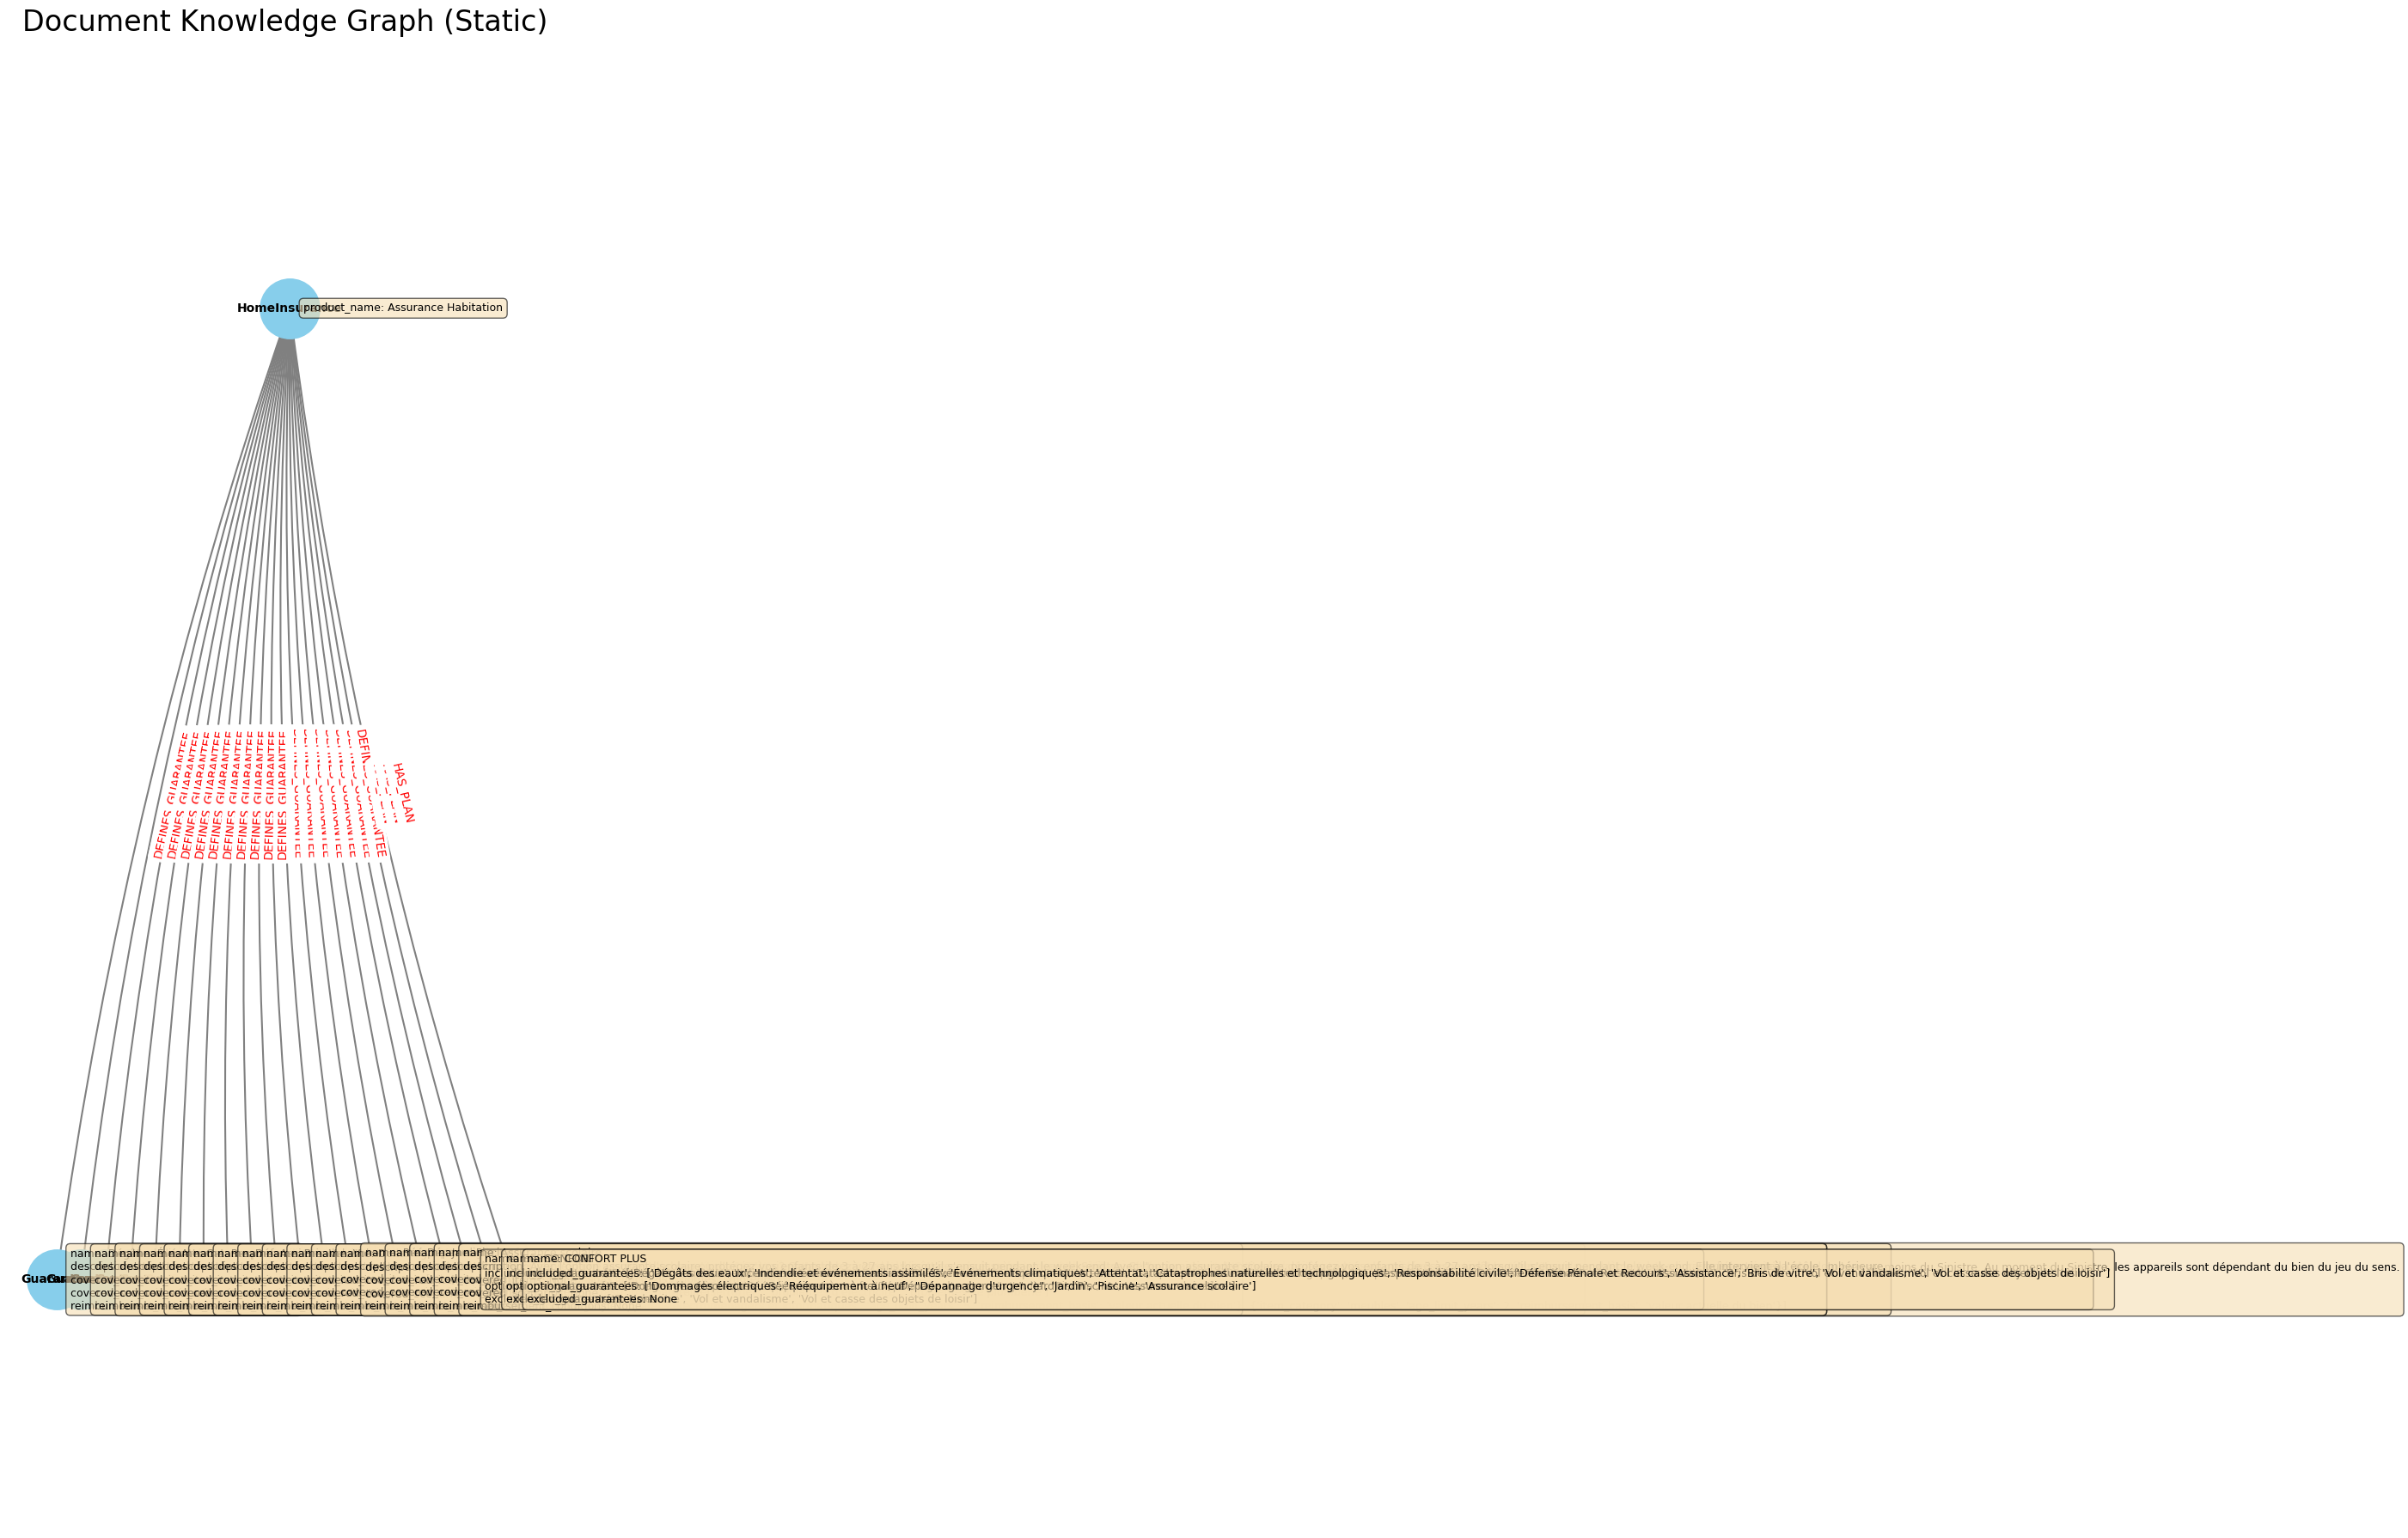

Static graph with properties saved to outputs\static_graph.png


Graph image created successfully.

In [26]:
if knowledge_graph:
    # Draw the graph and save it to a file
    static_image_file = "static_graph.png"
    create_static_graph(knowledge_graph, filename=static_image_file)
    print("[bold green]Graph image created successfully.[/bold green]")
else:
    print("No graph to visualize.")

### 5.3. Generate Interactive Visualization with Plotly

In [27]:
if knowledge_graph:
    # Create an Interactive Visualization with PyVis
    interactive_html_file = "interactive_graph.html"
    html_path = create_interactive_graph(knowledge_graph, filename=interactive_html_file)
    print("[bold green]Interactive graph created successfully.[/bold green]")
else:
    print("No graph to visualize.")

Interactive Plotly graph saved to: outputs\interactive_graph.html


Interactive graph created successfully.